## Reinforcement learning: Problem set 3 - soft policy iteration

### Juan Felipe Godoy

In this problem set I will implement the Soft Policy iteration in the MDP problem we have been working on. 

In [74]:
# Initial set up
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import random

In [75]:
# Properties of the MDP
N = 100 # Number of states
q_low = 0.51 #probability of action_low
q_high = 0.6 #probability of action_high
c_low = 0 #cost of action low
c_high = 0.01 #cost of action high
p = 0.5 #arrival rate
gamma=0.9 # discount factor

In [76]:
# Action high

m_high = np.zeros(shape=(N,N))
np.fill_diagonal(m_high,(p*q_high)+(1-p)*(1-q_high))

# right
for i in range(N-1):
    if i != N-1:
        m_high[i][i+1]=p*(1-q_high)
    if i == 0:
        m_high[i][i+1]=0.2
        m_high[i][i]=0.8

# Left
for i in range(N):
    if i != 0:
        m_high[i][i-1]=(1-p)*(q_high)
    if i == N-1:
        m_high[i][i-1]=0.3
        m_high[i][i]=0.7

print(m_high)

[[0.8 0.2 0.  ... 0.  0.  0. ]
 [0.3 0.5 0.2 ... 0.  0.  0. ]
 [0.  0.3 0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.2 0. ]
 [0.  0.  0.  ... 0.3 0.5 0.2]
 [0.  0.  0.  ... 0.  0.3 0.7]]


In [77]:
# Action low         
m_low = np.zeros(shape=(N,N))
np.fill_diagonal(m_low,(p*q_low)+(1-p)*(1-q_low))

# right
for i in range(N-1):
    if i != N-1:
        m_low[i][i+1]=p*(1-q_low)
    if i == 0:
        m_low[i][i+1]=0.245
        m_low[i][i]=0.755
# Left
for i in range(N):
    if i != 0:
        m_low[i][i-1]=(1-p)*(q_low)
    if i ==N-1:
        m_low[i][i-1]=0.255
        m_low[i][i]=0.745
print(m_low)

[[0.755 0.245 0.    ... 0.    0.    0.   ]
 [0.255 0.5   0.245 ... 0.    0.    0.   ]
 [0.    0.255 0.5   ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.5   0.245 0.   ]
 [0.    0.    0.    ... 0.255 0.5   0.245]
 [0.    0.    0.    ... 0.    0.255 0.745]]


In [78]:
# Reward function
def reward (q,x):    
    if q == q_low:
        r = -(x/N)**2 -c_low
    if  q == q_high:
        r = -(x/N)**2 -c_high   
    return r

def soft_reward (q,x):    
    r_1 = -(x/N)**2 - c_low
    r_2 = -(x/N)**2 - c_high
    r = q[0]*r_1 + q[1]*r_2
    return r

Above I included a new reward function that outputs the reward based on the stochastic nature of the problem. With probability q takes the calculates the reward of the action low and w.p. 1 -q the reward of the other action.

In [79]:
# Fine feature map:
def fine_feature (N,x):
    return np.eye(N)[x]

# Coarse feature map
def coarse_feature(N,x):
    final_vector = []
    for i in range(1,int(N/5)+1):
        lower_bound = 5*(i-1)
        upper_bound =5*i-1
        if lower_bound <= x <= upper_bound:
            final_vector.append(1)
        else:
            final_vector.append(0)
    return np.array(final_vector)


# Piecewise linear feature
def piecewise_feature(N,x):
    v1 = coarse_feature(N,x)
    v2 = coarse_feature(N,x)
    v3 = []
    for i in range(1,int(N/5)+1):
        v3.append((x-5*(i-1))/5)
    final_vector=np.multiply(v3,v2)
    return np.append(v1,final_vector) 

In [80]:
# Utilities

def feature_maps(maps,N,x):
    if maps == "fine":
        phi = fine_feature (N,x)
    elif maps == 'coarse':
        phi = coarse_feature(N,x)
    elif maps == 'piece':
        phi = piecewise_feature(N,x)
    return phi

def theta_vector(maps,N):
    if maps == "fine":
        theta = np.zeros(N) 
    elif maps == "coarse":
        theta = np.zeros(int(N/5))
    elif maps == "piece":
        theta = np.zeros(2*int(N/5))
    return theta  


def translate_policy(policy):
    return ['lazy' if i[0]==1 else 'aggressive' for i in policy]

def reverse_policy(policy):
    return[0 if i=='lazy' else 1 for i in policy]

def translate_policy_servicerate(policy):
    return [0.51 if i == 'lazy' else 0.60 for i in policy]


Now I define the function defined as soft_LSTD which in comparison of the previous LSTD (Homework 2) recieves the uniform policy $\pi_{1}(a/X)=1/|A|$.


In [81]:
# Soft LSTD

def soft_LSTD(N,max_iter,initial_state,maps,gamma,policy,policy_vector:None,m_low,m_high,q_low,q_high):
    value_vector = np.zeros(N)
    theta = theta_vector(maps,N)
    value = np.zeros(N)
    s = initial_state 

    
    # Define matrix by policy
    if policy == 'lazy':
        matrix = m_low
    elif policy == 'aggressive':
        matrix = np.vstack([m_low[0:50,:],m_high[50:N,:]])

   # New option of policy: Uniform
   # Build the matrix with the transition probabilities based on the random selction.     
    elif policy == 'uniform':
        matrix = np.zeros((N,N))

        for pi,ni in zip(policy_vector,list(range(N))):  
           
            row = np.multiply(m_low[ni,:],pi[0]) + np.multiply(m_high[ni,:],(pi[1]))
            
            matrix[ni,:] = row
         
             
    elif policy =='optimal':
        matrix = np.zeros((N,N))
        for pi,ni in zip(policy_vector,list(range(N))):
            if pi == 'lazy':
                row = m_low[ni,:]
            elif pi == 'aggressive':
                row = m_high[ni,:]
            matrix[ni,:] = row


    A_B_matrix = 0
    b = 0
    total_reward = 0
    # Iteration
    for t in range(max_iter):
        # reward vector
        reward_vector = []
        if policy == 'lazy':
            q=q_low
            
            for x in range(0,N):
                reward_vector.append(reward(q,x))
        
        elif policy == 'aggressive':
            for x in range(0,N):
                if x < 50:
                    q=q_low
                else:
                    q=q_high
                reward_vector.append(reward(q,x))

        elif policy =='optimal':
            for pi,ni in zip(policy_vector,list(range(N))):
                if pi == 'lazy':
                    q=q_low
                elif pi == 'aggressive':
                    q=q_high
                reward_vector.append(reward(q,ni))
        # Calculate the reward of the policy in each iteration
        elif policy == 'uniform':
            for pi,ni in zip(policy_vector,list(range(N))):
                reward_vector.append(soft_reward(pi,ni))


        s_pr = np.random.choice(list(range(0,100)), p=list(matrix[s]))
        mapping_x = np.matrix(feature_maps(maps,N,s))
        mapping_next = np.matrix(feature_maps(maps,N,s_pr))
        
        A_B_matrix += mapping_x.T*(mapping_x - gamma*mapping_next)
        b +=reward_vector[s]*mapping_x
        total_reward += reward_vector[s]
        s = s_pr

    A_B_matrix = np.linalg.pinv(A_B_matrix)
    theta = b*A_B_matrix    

    
    for j in range (N):
        value[j] = np.dot(theta, feature_maps(maps,N,j))
        
    return total_reward,s,value_vector  

In the following cell I introduce one of the main changes compared to the previous homework. 
Instead of improving the policy by selecting the action that maximizes the $\hat{Q}_k (a/x)$ we update the policy following the formula suggested in the problem.

In [82]:
# Defining the q function : Policy improvement
def q_function(values,gamma,eta,optimal_policy):
    for x in range(N):
        values_list = np.zeros(2)
        for q,m,n,pi in zip([q_low,q_high],[m_low,m_high],[0,1],['lazy','aggressive']):
            values[n] = reward(q,x) + 0.5*gamma*m[x,:].dot(values)
        # Policy update        
        optimal_policy[x,0]= optimal_policy[x,0]*np.exp(eta*values[0])/(optimal_policy[x,0]*np.exp(eta*values[0]) + optimal_policy[x,1]*np.exp(eta * values[1]))
        optimal_policy[x,1] = 1-optimal_policy[x,0]
    return optimal_policy

### Soft policy evaluation

In [86]:
result = pd.DataFrame(columns=['mapping','policy','eta','values','final_state','total_reward'])
mapping = 'piece'
policy = 'uniform'
K = 100
s_1 = 99
etas = np.logspace(-2,2, num = 10)

for eta in tqdm(etas):
    policy_updated = np.zeros((100,2)) + 0.5
    reward_value = 0
    for k in tqdm(range(K)):
        total_reward_1,s_1,value_vector_1 = soft_LSTD(max_iter=10000,N=100,initial_state=s_1,maps=mapping,gamma=0.9,policy=policy,policy_vector = policy_updated, m_low=m_low,m_high=m_high,q_high=q_high,q_low=q_low)
        reward_value += total_reward_1
        policy_updated = q_function(value_vector_1,gamma,eta,policy_updated)
        
    result = result.append({'mapping':mapping,'policy':policy,'eta':eta,'values':value_vector_1,'final_state':s_1,'total_reward':reward_value}, ignore_index=True)

100%|██████████| 10/10 [54:55<00:00, 329.59s/it]


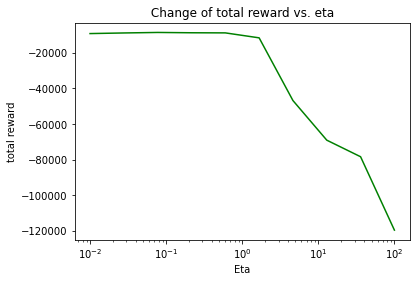

In [91]:
# Plot
fig, ax = plt.subplots()
plt.title(' Change of total reward vs. eta ')
plt.xlabel('Eta')
plt.ylabel('total reward')
ax.plot(result['eta'], result['total_reward'],color = 'g')
ax.set_xscale("log")
plt.show()

What we see from the figure above is that, on average, the total reward decreases as the $\eta$ increases. However, we can also notice that for relatively small values for the $\eta$, the total reward is constant and at a tipping point, it starts to decrease. 

This behavior supports the theoretical results we saw in class, suggesting that selecting values for  $\eta$ to low or high will result in extremely different scenarios. For our particular case we can conclude that the values of $\eta$ in the range of $10^{-2} and 10^{0}$ yield better results.  

Finally, we can also expect that results in the scenario with the soft_policy are better than those compared to the hard policy.